In [1]:
import gym
import swingUp
import numpy as np
import numpy.random as rnd
import torch as pt
import matplotlib.pyplot as plt
%matplotlib inline

Here is code from the previous assignment for convenience. 

In [13]:
class nnQ(pt.nn.Module):
    """
    Here is a basic neural network with for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.ReLU()]
        
        HiddenLayers = []
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32)

        b = pt.nn.functional.one_hot(pt.tensor(a),self.numActions)
        
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
            
class sarsaAgent:
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers,
                epsilon=.1,gamma=.9,alpha=.1):
        self.Q = nnQ(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
        
    def action(self,x):
        # This is an epsilon greedy selection
        if rnd.rand() < self.epsilon:
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0]
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None:
            Q_next = self.Q(s,a).detach().numpy()[0]
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
            
        # Update the parameter via the semi-gradient method
        if update:
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
                
        
            
            
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)


The simulation is slightly modified from the previous homework. In particular, the episode lengths are restricted to be at most 500. 

Episode: 1 Total Steps: 42 , Ave. Reward: -20.698997616864087 , Episode Length: 42 Max Up-Time: 14
Episode: 2 Total Steps: 81 , Ave. Reward: -13.986476015560857 , Episode Length: 39 Max Up-Time: 5
Episode: 3 Total Steps: 134 , Ave. Reward: -12.333068596779196 , Episode Length: 53 Max Up-Time: 0
Episode: 4 Total Steps: 170 , Ave. Reward: -17.610950598115593 , Episode Length: 36 Max Up-Time: 6
Episode: 5 Total Steps: 200 , Ave. Reward: 0.0 , Episode Length: 30 Max Up-Time: 0


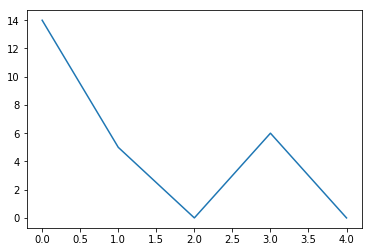

In [14]:
# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .95

agent = sarsaAgent(5,numActions,20,2,epsilon=5e-2,gamma=gamma,alpha=1e-4)
maxSteps = 2e2

# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]])

R = []
UpTime = []

step = 0
ep = 0
maxLen = 500
while step < maxSteps:
    ep += 1
    x = env.reset()
    C = 0.
    
    done = False
    t = 1
    while not done:
        t += 1
        step += 1 
        y = x_to_y(x)
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        x_next,c,done,info = env.step(u)
        
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)

        C += (1./t)*(c-C)
        agent.update(y,a,c,y_next,done)
        x = np.copy(x_next)
        if done:
            break
            
        if step >= maxSteps:
            break
            
        if t > maxLen:
            agent.s_last = None
            break
            
        
        R.append(C)
    UpTime.append(max_up_time)
    #print('t:',ep+1,', R:',C,', L:',t-1,', G:',G,', Q:', Q_est, 'U:', max_up_time)
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward:',C,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)
env.close()

plt.plot(UpTime)

# Question 

Implement deep Q-learning as described in the paper here:

https://daiwk.github.io/assets/dqn.pdf

In this paper, we have the states, and so there is no need to do the pre-processing described there.

In my tests on this problem, it works substantially better than the SARSA  implementation 
with the following design choices:
* Use the same Q-network architecture as used  in the SARSA algorithm
* Same step size, discount factor, and learning rate as above
* Mini-batch size of 20
* Update the target network every 100 steps

The deep Q-learning method can be implemented via a modification of the SARSA code above.

You could probably make it work even better with further tuning.


In [ ]:
# Implement this code below and test it.

In [22]:
class dqnAgent(sarsaAgent):
    '''
    methods of sarsaAgent
    __init__
    action(x) -> a
    update(s,a,r,s_next,done) -> null
    '''
    
    def __init__(self, stateDim, numActions, numHiddenUnits, numLayers, 
                 epsilon=.1, gamma=.9, alpha=.1, 
                 bufferSize = 2e4, batchSize = 20, time_step = 100):
        
        super().__init__(stateDim, numActions, numHiddenUnits, numLayers, epsilon, gamma, alpha)
        
        self.memory_s = []
        self.memory_a = []
        self.memory_r = []
        self.memory_sn = []
        self.memory_d = []
        
        self.bufferSize = bufferSize
        self.batchSize = batchSize
        self.time_step = time_step
        
        
        self.epsilon_start = 0.99
        self.epsilon_end = epsilon
        self.epsilon_decay = 5e3
        
        self.Q_t = nnQ(stateDim,numActions,numHiddenUnits,numLayers)
        self.Q_t.load_state_dict(self.Q.state_dict())
    
    
    def store(self,s,a,r,s_next,done):
        # keep the buffer size no bigger than bufferSize
        if len(self.memory_s) > self.bufferSize:
            self.memory_s.pop(0)
            self.memory_a.pop(0)
            self.memory_r.pop(0)
            self.memory_sn.pop(0)
            self.memory_d.pop(0)
        self.memory_s.append(s)
        self.memory_a.append(a)
        self.memory_r.append(r)
        self.memory_sn.append(s_next)
        self.memory_d.append(done)


    # Reload method 'update' from SARSA to Q-learning.
    def update(self,s,a,r,s_next,done):
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0]
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None:
            # Find 'max_a Q_t(s,a)'
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q_t(s,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    aBest = aTest
            Q_next = qBest
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
        
        # Update the parameter via the semi-gradient method
        if update:
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)
            
    
    def optimize(self):
        # print("Neural Network is being updated")
        bufferlen = min(self.batchSize, len(self.memory_s))
        for i in rnd.randint(0, bufferlen, 1):
            s = self.memory_s[i]
            a = self.memory_a[i]
            r = self.memory_r[i]
            s_next = self.memory_sn[i]
            done = self.memory_d[i]
            
            self.update(s,a,r,s_next,done)
            

Episode: 1 Total Steps: 66 , Ave. Reward: -8.559960508554756 , Episode Length: 65 Max Up-Time: 0
Episode: 2 Total Steps: 204 , Ave. Reward: -4.407009015656422 , Episode Length: 137 Max Up-Time: 0
Episode: 3 Total Steps: 311 , Ave. Reward: -7.241283804531687 , Episode Length: 106 Max Up-Time: 0
Episode: 4 Total Steps: 370 , Ave. Reward: -10.216026430739182 , Episode Length: 58 Max Up-Time: 0
Episode: 5 Total Steps: 490 , Ave. Reward: -2.102323802290705 , Episode Length: 119 Max Up-Time: 0
Episode: 6 Total Steps: 570 , Ave. Reward: -5.246160803146396 , Episode Length: 79 Max Up-Time: 0
Episode: 7 Total Steps: 698 , Ave. Reward: -3.8464297968861234 , Episode Length: 127 Max Up-Time: 0
Episode: 8 Total Steps: 824 , Ave. Reward: -4.1278944161930475 , Episode Length: 125 Max Up-Time: 0
Episode: 9 Total Steps: 973 , Ave. Reward: -1.2972527621276797 , Episode Length: 148 Max Up-Time: 0
Episode: 10 Total Steps: 1078 , Ave. Reward: -6.940882257908681 , Episode Length: 104 Max Up-Time: 0
Episode:

Episode: 83 Total Steps: 5670 , Ave. Reward: -8.700510830284223 , Episode Length: 61 Max Up-Time: 18
Episode: 84 Total Steps: 5713 , Ave. Reward: -13.800292914500126 , Episode Length: 42 Max Up-Time: 0
Episode: 85 Total Steps: 5768 , Ave. Reward: -13.428217399109664 , Episode Length: 54 Max Up-Time: 3
Episode: 86 Total Steps: 5814 , Ave. Reward: -11.426651872493771 , Episode Length: 45 Max Up-Time: 0
Episode: 87 Total Steps: 5859 , Ave. Reward: -16.00480833162807 , Episode Length: 44 Max Up-Time: 0
Episode: 88 Total Steps: 5920 , Ave. Reward: -6.582010608555331 , Episode Length: 60 Max Up-Time: 3
Episode: 89 Total Steps: 5971 , Ave. Reward: -16.84819165818509 , Episode Length: 50 Max Up-Time: 0
Episode: 90 Total Steps: 6017 , Ave. Reward: -16.536890800814582 , Episode Length: 45 Max Up-Time: 0
Episode: 91 Total Steps: 6061 , Ave. Reward: -17.679330849010082 , Episode Length: 43 Max Up-Time: 0
Episode: 92 Total Steps: 6110 , Ave. Reward: -10.683950914979764 , Episode Length: 48 Max Up-T

Episode: 164 Total Steps: 10658 , Ave. Reward: -17.510994485468075 , Episode Length: 36 Max Up-Time: 0
Episode: 165 Total Steps: 10694 , Ave. Reward: -18.135237037448757 , Episode Length: 35 Max Up-Time: 0
Episode: 166 Total Steps: 10728 , Ave. Reward: -18.641299871517468 , Episode Length: 33 Max Up-Time: 0
Episode: 167 Total Steps: 10768 , Ave. Reward: -15.810222915645426 , Episode Length: 39 Max Up-Time: 10
Episode: 168 Total Steps: 10801 , Ave. Reward: -25.773279526295 , Episode Length: 32 Max Up-Time: 3
Episode: 169 Total Steps: 10837 , Ave. Reward: -15.780629669532171 , Episode Length: 35 Max Up-Time: 0
Episode: 170 Total Steps: 10877 , Ave. Reward: -17.042555893518436 , Episode Length: 39 Max Up-Time: 0
Episode: 171 Total Steps: 10911 , Ave. Reward: -19.92080011231462 , Episode Length: 33 Max Up-Time: 3
Episode: 172 Total Steps: 10956 , Ave. Reward: -15.297604354043095 , Episode Length: 44 Max Up-Time: 0
Episode: 173 Total Steps: 10998 , Ave. Reward: -17.532785330539006 , Episode

Episode: 244 Total Steps: 14356 , Ave. Reward: -11.92811743570468 , Episode Length: 38 Max Up-Time: 0
Episode: 245 Total Steps: 14394 , Ave. Reward: -13.947853428278515 , Episode Length: 37 Max Up-Time: 0
Episode: 246 Total Steps: 14445 , Ave. Reward: -15.33099357881747 , Episode Length: 50 Max Up-Time: 0
Episode: 247 Total Steps: 14483 , Ave. Reward: -14.166203231810213 , Episode Length: 37 Max Up-Time: 0
Episode: 248 Total Steps: 14517 , Ave. Reward: -13.312966095032808 , Episode Length: 33 Max Up-Time: 0
Episode: 249 Total Steps: 14556 , Ave. Reward: -12.240303803220115 , Episode Length: 38 Max Up-Time: 8
Episode: 250 Total Steps: 14593 , Ave. Reward: -16.898701412905886 , Episode Length: 36 Max Up-Time: 10
Episode: 251 Total Steps: 14635 , Ave. Reward: -15.08701051112091 , Episode Length: 41 Max Up-Time: 0
Episode: 252 Total Steps: 14676 , Ave. Reward: -16.90308700364535 , Episode Length: 40 Max Up-Time: 0
Episode: 253 Total Steps: 14713 , Ave. Reward: -15.335283676591175 , Episode

Episode: 324 Total Steps: 18048 , Ave. Reward: -17.412020404514823 , Episode Length: 43 Max Up-Time: 0
Episode: 325 Total Steps: 18098 , Ave. Reward: -16.32461065500751 , Episode Length: 49 Max Up-Time: 0
Episode: 326 Total Steps: 18141 , Ave. Reward: -15.79863780956686 , Episode Length: 42 Max Up-Time: 0
Episode: 327 Total Steps: 18178 , Ave. Reward: -14.01599813606989 , Episode Length: 36 Max Up-Time: 0
Episode: 328 Total Steps: 18220 , Ave. Reward: -12.513653207373734 , Episode Length: 41 Max Up-Time: 13
Episode: 329 Total Steps: 18270 , Ave. Reward: -15.980250468266286 , Episode Length: 49 Max Up-Time: 0
Episode: 330 Total Steps: 18306 , Ave. Reward: -11.8621760764171 , Episode Length: 35 Max Up-Time: 0
Episode: 331 Total Steps: 18415 , Ave. Reward: -12.384338354633732 , Episode Length: 108 Max Up-Time: 36
Episode: 332 Total Steps: 18536 , Ave. Reward: -10.150572247093532 , Episode Length: 120 Max Up-Time: 46
Episode: 333 Total Steps: 18633 , Ave. Reward: -15.7659687881403 , Episod

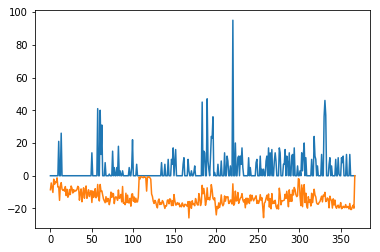

In [24]:
# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .95

agent = dqnAgent(5,numActions,20,2,epsilon=0.02,gamma=gamma,alpha=1e-4,
                 bufferSize=2e4, batchSize=256, time_step=100)
maxSteps = 2e4
T = 500

# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]])

Returns = []
UpTime = []

step = 0
epi = 0

eps_start = agent.epsilon_start
eps_end = agent.epsilon_end
eps_decay = agent.epsilon_decay

while step < maxSteps:
    epi = epi + 1

    x = env.reset()
    avgR = 0.
    done = False
    t = 0
    
    while not done and t < T:
        t += 1
        step += 1
        agent.epsilon = eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay)
        
        y = x_to_y(x)
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        x_next,r,done,info = env.step(u)
        
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)

        avgR = avgR + (1./t)*(r-avgR)
        agent.store(y,a,r,y_next,done)
        agent.optimize()
        
        if step % agent.time_step == 0:
            agent.Q_t.load_state_dict(agent.Q.state_dict())
        
        x = np.copy(x_next)
        
        if done:
            break

        if step >= maxSteps:
            break
        
        if t > T:
            agent.s_last = None
            break
            
    Returns.append(avgR)
    UpTime.append(max_up_time)
    print('Episode:',epi,'Total Steps:',step,', Ave. Reward:',avgR,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)

env.close()

plt.plot(UpTime)
plt.plot(Returns)

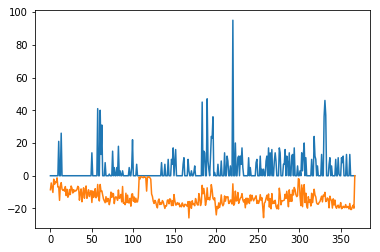

In [25]:
plt.plot(UpTime)
plt.plot(Returns)